In [1]:
from tournament.agents.constant import AllC, AllD
from tournament.agents.pavlov import Pavlov
from tournament.agents.q_learning.dqn import DeepQLearner
from tournament.agents.tft import TFTT, GenerousTFT, TitForTat
from tournament.environments.single import SingleRuleBasedAgentEnvironment
from tournament.environments.multiple import MultipleRuleBasedAgentEnvironment
from tournament.agents.agents import AGENTS
from tournament.agents.axelrod_first import (
    Davis,
    Downing,
    Feld,
    Grofman,
    Grudger,
    Joss,
    Nydegger,
    Shubik,
    SteinAndRapoport,
    TidemanAndChieruzzi,
    Tullock,
)
from tournament.agents.tft import (
    TFTT,
    TTFT,
    GenerousTFT,
    GradualTFT,
    OmegaTFT,
    TitForTat,
)
from tournament.tournament import RoundRobinTournament

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# env = SingleRuleBasedAgentEnvironment(TitForTat)
env = MultipleRuleBasedAgentEnvironment([
    TitForTat,
    # AllC,
    TFTT,
    TTFT,
    GenerousTFT,
    # GradualTFT,
    OmegaTFT,
])

In [3]:
class QNetwork(nn.Module):
    def __init__(self, lookback):
        super().__init__()

        # self.elu = nn.ELU()

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(2 * lookback, 32)
        self.layer2 = nn.Linear(32, 32)
        # self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 2)

        nn.init.kaiming_uniform_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        # nn.init.kaiming_uniform_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.unsqueeze(dim=0)
        x = self.flatten(x)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        # x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))

        return x

class QLearningTest(DeepQLearner):
    lookback = 8
    epsilon = 0.15

    def __init__(self):
        super().__init__()

        self._learning_rate = 0.15
        self._q_network = QNetwork(self.lookback)


agent = QLearningTest()

In [4]:
env.train(
    trainee=agent,
    continuation_probability=1,
    limit=250,
    noise=0,
    repetitions=1,
    epochs=10,
)

[02:18:04] Commencement of training.
[02:18:09] Completed epoch 1: 2.4985546175420286
[02:18:13] Completed epoch 2: 2.480677308771014
[02:18:16] Completed epoch 3: 2.485251539180676
[02:18:20] Completed epoch 4: 2.4805386543855072
[02:18:23] Completed epoch 5: 2.4771509235084057
[02:18:26] Completed epoch 6: 2.477759102923671
[02:18:28] Completed epoch 7: 2.4777935167917184
[02:18:30] Completed epoch 8: 2.4773193271927534
[02:18:32] Completed epoch 9: 2.473306068615781
[02:18:35] Completed epoch 10: 2.471655461754203


In [5]:
print(agent._q_network)
print(env.counts)

s = sum(env.counts.values())

print({a: env.counts[a] / s for a in env.counts})

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=2, bias=True)
)
{<Action.COOPERATE: 0>: 11538, <Action.DEFECT: 1>: 962}
{<Action.COOPERATE: 0>: 0.92304, <Action.DEFECT: 1>: 0.07696}


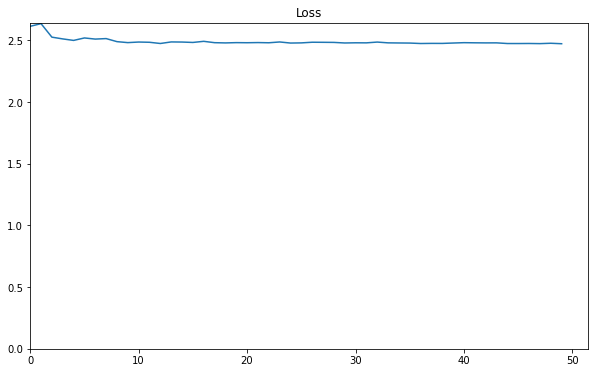

In [6]:
plt.title("Loss")
plt.plot(env.metric_history)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

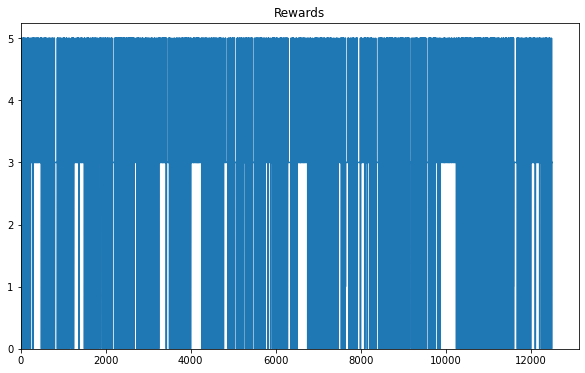

In [7]:
plt.title("Rewards")
plt.plot(env.rewards)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

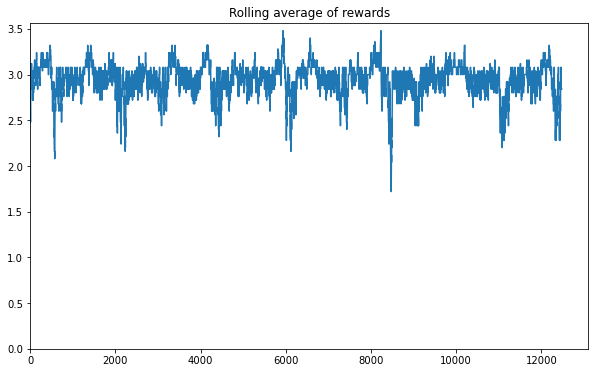

In [8]:
N = 25

plt.title("Rolling average of rewards")
plt.plot(np.convolve(env.rewards, np.ones(N), mode='valid') / N)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

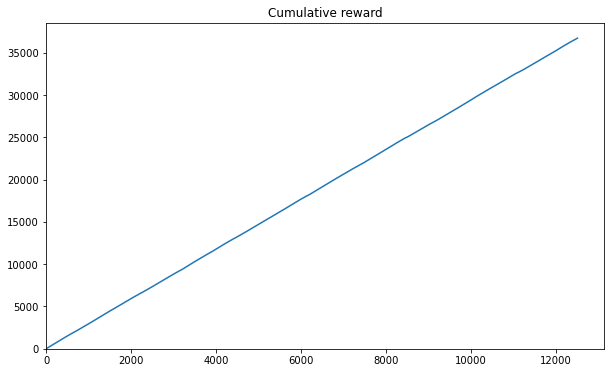

In [9]:
plt.title("Cumulative reward")
plt.plot(np.cumsum(env.rewards))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

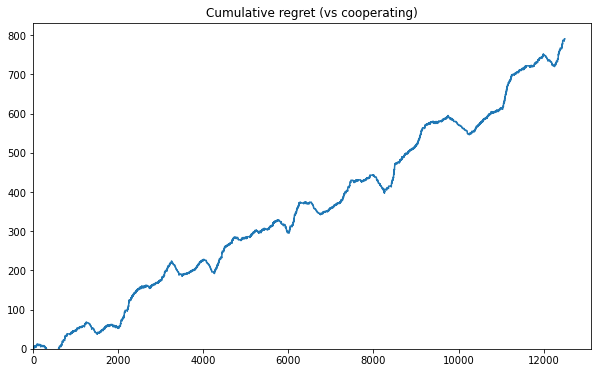

In [10]:
plt.title("Cumulative regret (vs cooperating)")
plt.plot(np.cumsum(3 - np.array(env.rewards)))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [11]:
# torch.save(agent._q_network.state_dict(), "model.pt")

In [12]:
agent._q_network.eval()

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=2, bias=True)
)

In [13]:
tournament = RoundRobinTournament(AGENTS, [agent])

scores, times = tournament.play(
    continuation_probability=0.99654, repetitions=20, jobs=12
)

results = [
    (agent, round(sum(scores[agent]) / len(scores[agent])), sum(times[agent]))
    for agent in scores
]
results.sort(key=lambda x: x[1], reverse=True)

for c, score, time in results:
    print(f"{c.__name__:<30} {score:<20} {time:<20}")


100%|██████████| 961/961 [01:14<00:00, 12.94matches/s]

SteinAndRapoport               853                  24.632001           
Borufsen                       829                  9.276386000000002   
Grudger                        808                  6.88274             
SecondByBlackK83R              808                  10.346218999999998  
SecondByGraaskampKatzen        806                  7.657366            
OmegaTFT                       804                  7.932495            
Shubik                         797                  7.157896000000001   
TTFT                           794                  6.582530000000001   
Champion                       793                  41.453013000000006  
Davis                          789                  12.089981999999996  
Grofman                        786                  7.095767            
SecondByWeiner                 778                  21.732439999999997  
SecondByWhiteK72R              773                  8.285990000000002   
TFTT                           767                 